In [1]:
#Importación de librearías necesarias
import pandas as pd
from datetime import datetime
import socket
import numpy as np
import math
import time
import pickle  #Para guardar archivos
import os
os.environ['OMP_NUM_THREADS'] = '1'

from pympler import asizeof #Para liberar memoria
import gc

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb

from sklearn import metrics
from sklearn.cluster import KMeans
import kneed

semilla = 8

In [2]:
#Path general de archivos
if socket.gethostname()=='LAPTOP-PUSGG08B': #Ip de la laptop
    ruta = "E:/Cristian Guatemal/Master/Big Data y Ciencia de Datos/VIU_TFM/Data/TFM/"
    r_ruta = "E:/Cristian Guatemal/Master/Big Data y Ciencia de Datos/VIU_TFM/RData/TFM/"
elif socket.gethostname()=='PCUIOMTDAIE6382': #Ip del working
    ruta =   "D:/Master/Big_Data_Ciencia_Datos/VIU_TFM/Data/TFM/"
    r_ruta = "D:/Master/Big_Data_Ciencia_Datos/VIU_TFM/RData/TFM/"
# Ruta del archivo de pensionistas de vejez
ruta_vj = ruta + 'POB_VEJ_CD656_NEW.dsv'
# Ruta del archivo de historia laboral de pensionistas
ruta_afi = ruta + 'APORTES_CD656_new.dsv'

In [3]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_clean_afi_sel_g_all_2.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    data_l = pickle.load( archivo )     

In [4]:
data_l.shape #(62130167, 16)

(62130167, 16)

In [5]:
inicio = time.time()
data_l = data_l.sort_values( by=["CEDULA_COD","ANIO", "MES"], ascending=[ True, True, True] )
data_l.reset_index(inplace=True)
data_l.rename(columns={'index': 'nuevo_indice'}, inplace=True)
data_l.drop(columns=['nuevo_indice'], inplace=True)
data_l['INDICE'] = data_l.index

#Casos de no análisis
data_no_grupo = data_l[ (data_l['GRUPO_SEL']==0) ].copy()
data_no_grupo['ATI_CJ_M1'] = np.nan
data_no_grupo['ATI_CJ_M2'] = np.nan
data_no_grupo['ATI_CJ_M3'] = np.nan

#Casos de análisis
data = data_l[ (data_l['GRUPO_SEL']==1) ].copy()

fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

Tiempo de ejecución es:  0.0  horas con  0.0  minutos y 59.46226954460144  segundos


In [6]:
data

,CEDULA_COD,ANIO,MES,SALARIO,SALARIO_SECTOR,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,GRUPO_SEL,INI_CAL,FIN_CAL,BASE_CAL,SBU,ID_SBU,INDICE
13,126,2006,1,161.67,161.67,PRI,1,1,5,161.670000,1,2010-12-01,2006-01-01,210.635,160.0,-1,13
14,126,2006,2,161.67,161.67,PRI,1,1,5,161.670000,1,2010-12-01,2006-01-01,210.635,160.0,-1,14
15,126,2006,3,161.67,161.67,PRI,1,1,5,161.670000,1,2010-12-01,2006-01-01,210.635,160.0,-1,15
16,126,2006,4,161.67,161.67,PRI,1,1,5,161.670000,1,2010-12-01,2006-01-01,210.635,160.0,-1,16
17,126,2006,5,161.67,161.67,PRI,1,1,5,161.670000,1,2010-12-01,2006-01-01,210.635,160.0,-1,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62130162,23594465,2017,11,14045.72,14045.72,PRI,1,1,1,16205.699167,1,2018-03-01,2013-04-01,16604.299,375.0,-1,62130162
62130163,23594465,2017,12,14164.25,14164.25,PRI,1,1,1,16205.699167,1,2018-03-01,2013-04-01,16604.299,375.0,-1,62130163
62130164,23594465,2018,1,12903.21,12903.21,PRI,1,1,1,16205.699167,1,2018-03-01,2013-04-01,16604.299,386.0,-1,62130164
62130165,23594465,2018,2,42432.21,42432.21,PRI,1,1,1,16205.699167,1,2018-03-01,2013-04-01,16604.299,386.0,-1,62130165


In [7]:
data_si = data[  (( data['SALARIO'] >= data['SBU'] ) & ( data['ANIO'] >= 2000 )) ].copy() 
data_no = data[ ~(( data['SALARIO'] >= data['SBU'] ) & ( data['ANIO'] >= 2000 )) ].copy() 

In [8]:
data_si_dic = data_si.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')
data_no_dic = data_no.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')

In [165]:
#Determinación del número de cluster según el método del codo y Silueta
def max_clust_silueta( silhouettes ):
    valor_cercano = silhouettes[0]
    indice_cercano = 0
    
    for indice, valor in enumerate(silhouettes):
        if abs(1 - valor) < abs(1 - valor_cercano):
            valor_cercano = valor
            indice_cercano = indice
            
    indice_cercano  = indice_cercano + 2
    return( indice_cercano )

def num_cluster( data_si_dic, num ):
    print('*' * 10, 'Determinación del número de clúster por el método del codo y silueta', '*' * 10)
    inicio = time.time()
    
    for ced  in data_si_dic:
        aux = None
        aux = np.unique( np.array( data_si_dic[ced]['SALARIO']) ).reshape(-1, 1)
        
        data_si_dic[ced]['distorsion'] = []
        data_si_dic[ced]['silueta'] = []
        
        tf = min(num, len(aux) - 1) + 1

        for i in range( 2, tf ):
            km = KMeans( i, init = 'k-means++', n_init = 1, max_iter = 300, tol = 1e-4, random_state = semilla )
            clustering = km.fit_predict( aux )

            if( len( np.unique( clustering ) ) > 1):
                data_si_dic[ced]['distorsion'].append( km.inertia_ )
                data_si_dic[ced]['silueta'].append( metrics.silhouette_score( aux, clustering ) )
            
            else:
                data_si_dic[ced]['distorsion'] = [0] 
                data_si_dic[ced]['silueta'] =  [0] 
    
        if( len( data_si_dic[ced]['distorsion'] ) > 1 & len( data_si_dic[ced]['silueta'] ) > 1 ):
            data_si_dic[ced]['num_codo'] = kneed.KneeLocator( range( 2, tf ), 
                                                              data_si_dic[ced]['distorsion'][ :num ],
                                                              curve="convex", direction="decreasing" ).elbow
    
            data_si_dic[ced]['max_silueta'] =  max_clust_silueta( data_si_dic[ced]['silueta'] )
        
        else:
            data_si_dic[ced]['num_codo'] = 1
            data_si_dic[ced]['max_silueta'] = 1
            
    return data_si_dic

    fin = time.time()  
    print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
    print('*' * 102)

In [166]:
num = 4
a = num_cluster( data_si_dic, num )

********** Determinación del número de clúster por el método del codo y silueta **********


KeyboardInterrupt: 

In [156]:
 np.unique( np.array( data_si_dic[126]['SALARIO']) ).reshape(-1, 1)

array([[161.67],
       [170.  ],
       [200.  ],
       [250.  ]])

In [163]:
print('*' * 10, 'Determinación del número de clúster por el método del codo y silueta', '*' * 10)
inicio = time.time()
num=4
for ced  in data_si_dic:
    aux = None
    aux = np.unique( np.array( data_si_dic[ced]['SALARIO']) ).reshape(-1, 1)

    data_si_dic[ced]['distorsion'] = []
    data_si_dic[ced]['silueta'] = []
   
    for i in range(2, min(num, len(aux) - 1) + 1):
        km = KMeans( i, init='random', n_init = 10, max_iter = 300, tol = 1e-4, random_state = semilla )
        clustering = km.fit_predict( aux )
        
        if len( np.unique( clustering ) ) > 1:
            data_si_dic[ced]['distorsion'].append( km.inertia_ )
            data_si_dic[ced]['silueta'].append( metrics.silhouette_score( aux, clustering ) )
            
        else:
            data_si_dic[ced]['distorsion'] = [0]
            data_si_dic[ced]['silueta'] = [0]
            
    if( len( data_si_dic[ced]['distorsion'] ) > 1 & len( data_si_dic[ced]['silueta'] ) ):
        
        data_si_dic[ced]['num_codo'] = kneed.KneeLocator( range(2, min(num, len(aux)) + 1 ), 
                                          data_si_dic[ced]['distorsion'][ :num ],
                                          curve="convex", direction="decreasing" ).elbow
        data_si_dic[ced]['max_silueta'] =  max_clust_silueta( data_si_dic[ced]['silueta'] )
        
    else:
        data_si_dic[ced]['num_codo'] = 1
        data_si_dic[ced]['max_silueta'] = 1
        

********** Determinación del número de clúster por el método del codo y silueta **********


ValueError: x and y arrays must be equal in length along interpolation axis.

In [162]:
#range(2, min(num, len(aux)) + 1)
#len(aux)
metrics.silhouette_score( aux, clustering )

ValueError: Number of labels is 4. Valid values are 2 to n_samples - 1 (inclusive)

In [164]:
ced=126
aux = None
aux = np.unique( np.array( data_si_dic[ced]['SALARIO']) ).reshape(-1, 1)

data_si_dic[ced]['distorsion'] = []
data_si_dic[ced]['silueta'] = []

for i in range(2, min(num, len(aux) - 1) + 1):
    km = KMeans( i, init='random', n_init = 10, max_iter = 300, tol = 1e-4, random_state = semilla )
    clustering = km.fit_predict( aux )

    if len( np.unique( clustering ) ) > 1:
        data_si_dic[ced]['distorsion'].append( km.inertia_ )
        data_si_dic[ced]['silueta'].append( metrics.silhouette_score( aux, clustering ) )

    else:
        data_si_dic[ced]['distorsion'] = [0]
        data_si_dic[ced]['silueta'] = [0]

# if( len( data_si_dic[ced]['distorsion'] ) > 1 & len( data_si_dic[ced]['silueta'] ) ):

#     data_si_dic[ced]['num_codo'] = kneed.KneeLocator( range(2, min(num, len(aux)) + 1 ), 
#                                       data_si_dic[ced]['distorsion'][ :num ],
#                                       curve="convex", direction="decreasing" ).elbow
#     data_si_dic[ced]['max_silueta'] =  max_clust_silueta( data_si_dic[ced]['silueta'] )

# else:
#     data_si_dic[ced]['num_codo'] = 1
#     data_si_dic[ced]['max_silueta'] = 1


In [93]:
distortions = []
silhouettes = []

data = np.array( data_si_dic[3057]['SALARIO'] ).reshape(-1, 1)
for i in range(2, 10):
    km = KMeans( i, init='random', n_init=10, max_iter=300, tol=1e-4, random_state = semilla)
    clustering = km.fit_predict(data )
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score( data, clustering))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

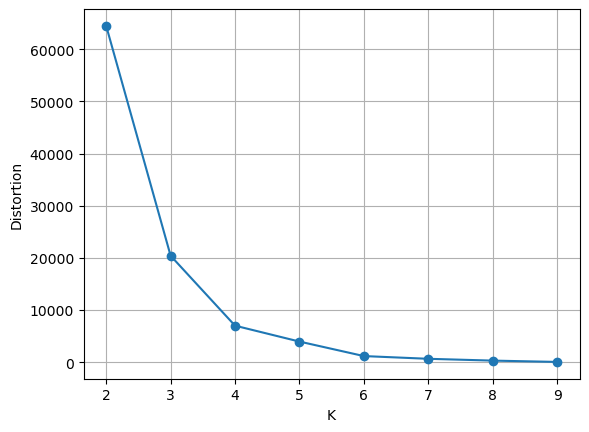

In [25]:
plt.plot(range(2,10), distortions, marker='o')
plt.xticks(range(2, 10))
plt.xlabel('K')
plt.ylabel('Distortion')
plt.grid(True)
plt.show()

Elbow:  4


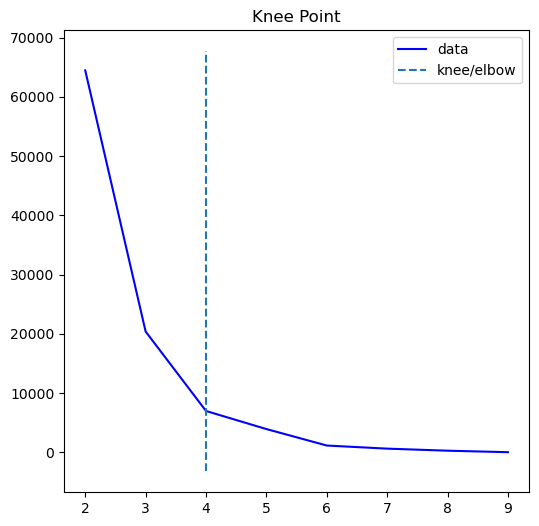

In [26]:
kneedle = kneed.KneeLocator(range(2, 10), distortions[:20], curve="convex", direction="decreasing")
elbow_point = kneedle.elbow
print('Elbow: ', elbow_point)
kneedle.plot_knee()

In [22]:
distortions


[64467.484003588535,
 20402.54989407947,
 6994.553560336138,
 3945.8513658508464,
 1165.7324623214308,
 642.4360337499999,
 295.22791375000054,
 43.85752000000007]

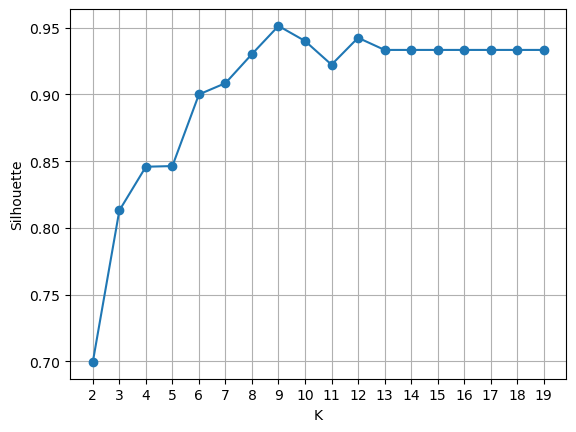

In [54]:
plt.plot(range(2,20), silhouettes , marker='o')
plt.xticks(range(2, 20))
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.grid(True)
plt.show()

In [39]:
silhouettes

[0.6995889246329805,
 0.8130470005984992,
 0.8458259500251094,
 0.97,
 0.97,
 0.9084506412944163,
 0.9302437828994431,
 0.9513189560536675]

In [43]:
valor_cercano = silhouettes[0]

# Iterar a través de los valores para encontrar el más cercano a 1
indice_cercano = 0

# Iterar a través de los valores para encontrar el más cercano a 1
for indice, valor in enumerate(silhouettes):
    if abs(1 - valor) < abs(1 - valor_cercano):
        valor_cercano = valor
        indice_cercano = indice
indice_cercano+=1
# Imprimir el valor más cercano y su índice
print(f"Valor más cercano a 1: {valor_cercano}")
print(f"Índice del valor: {indice_cercano}")

Valor más cercano a 1: 0.97
Índice del valor: 4


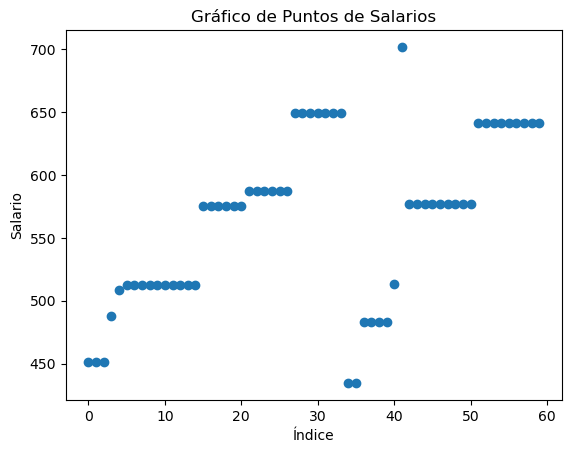

In [55]:
plt.scatter( np.arange(np.array( data_si_dic[216]['SALARIO'] ).shape[0]), np.array( data_si_dic[216]['SALARIO'] ) )

# Añadir etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Salario')
plt.title('Gráfico de Puntos de Salarios')

# Mostrar el gráfico
plt.show()